In [124]:
from hydra import initialize, compose
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import mlflow
from collections import defaultdict
from src.utils import load_json
from rdkit import Chem
from src.cheminfo import draw_molecule, draw_reaction
from IPython.display import SVG

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [16]:
with initialize(version_base=None, config_path="../configs/filepaths"):
    filepaths = compose(config_name="base")

embed_path = Path(filepaths.results) / "embeddings"
mlflow.set_tracking_uri(filepaths.tracking_uri)
production_models = mlflow.search_runs(filter_string="params.'data/split_idx' = '-2'")
production_models.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.train_loss,metrics.epoch,params.data/dataset,params.data/n_splits,...,params.exp,params.data/embed_type,params.model/agg,params.init_lr,params.data/neg_multiple,params.training/pos_multiplier,tags.mlflow.user,tags.mlflow.runName,tags.mlflow.source.name,tags.mlflow.source.type
0,84dea227b45b46fb80a5d5559798ff64,0,FINISHED,file:///projects/p30041/spn1560/hiec/results/r...,2025-02-15 15:34:47.978000+00:00,2025-02-15 19:34:14.366000+00:00,0.002171,24.0,sprhea,3,...,None,esm,LastAggregation,0.0001,3,3,spn1560,gifted-kite-152,/home/spn1560/.conda/envs/hiec/lib/python3.11/...,LOCAL
1,4766fb380a3e4cd0b2735be4f1d5ee15,0,FINISHED,file:///projects/p30041/spn1560/hiec/results/r...,2025-02-15 15:20:39.976000+00:00,2025-02-15 19:30:59.851000+00:00,0.011421,24.0,sprhea,3,...,None,esm,MeanAggregation,0.0001,3,3,spn1560,fortunate-doe-560,/home/spn1560/.conda/envs/hiec/lib/python3.11/...,LOCAL


In [53]:
krs = load_json(Path(filepaths.data) / "sprhea/v3_folded_pt_ns.json")

In [23]:
for _, row in production_models.iterrows():
    print(f"ID: {row['run_id']}, Name: {row['params.model/name']}")

ID: 84dea227b45b46fb80a5d5559798ff64, Name: rc_agg
ID: 4766fb380a3e4cd0b2735be4f1d5ee15, Name: bom


Merge reaction embeddings & label reactions w/ r-hop clusters

In [110]:
tol = 1e-8
r_hop_range = [i for i in range(4)]
model_embeds = {}
for run_id in production_models['run_id']:
    df = pd.read_parquet(embed_path / run_id / "radial_mask_False/r_hop_1" / "reaction_embeddings.parquet")
    df.drop(columns='reaction_idx', inplace=True)

    for r in r_hop_range:
        cg = pd.read_parquet(embed_path / run_id / f"radial_mask_True/r_hop_{r}" / "reaction_embeddings.parquet")
        cg.rename(columns={"embedding": f"{r}_hop_embedding"}, inplace=True)
        cg.drop(columns='reaction_idx', inplace=True)
        df = pd.merge(df, cg, on="rid", how='inner')

    for r in r_hop_range:
        r_clusters = []
        anchor_embeds = []
        for embed in df[f"{r}_hop_embedding"]:
            for i, ae in enumerate(anchor_embeds):
                if np.allclose(embed, ae):
                    r_clusters.append(i)
                    break
            else:
                r_clusters.append(len(anchor_embeds))
                anchor_embeds.append(embed)
        df[f"{r}_hop_cluster"] = r_clusters


    model_embeds[run_id] = df
    


In [95]:
df.head()

,rid,embedding,0_hop_embedding,1_hop_embedding,2_hop_embedding,3_hop_embedding,0_hop_cluster,1_hop_cluster,2_hop_cluster,3_hop_cluster
0,7694,"[-0.0004934121, -0.40490463, -0.0010001124, -0...","[-0.0004934121, -0.42844602, -0.0010001124, -0...","[-0.0004934121, 2.4079742, -0.0010001124, -0.1...","[-0.0004934121, 0.20007215, -0.0010001124, -0....","[-0.0004934121, -0.2689423, -0.0010001124, -0....",0,0,0,0
1,5969,"[-0.0004934121, -0.40490463, -0.0010001124, 0....","[-0.0004934121, -0.42844602, -0.0010001124, 0....","[-0.0004934121, -0.5299844, -0.0010001124, 0.0...","[-0.0004934121, -0.3211836, -0.0010001124, -0....","[-0.0004934121, -0.2689423, -0.0010001124, 0.2...",1,1,1,1
2,12653,"[-0.0004934121, -0.40490463, -0.0010001124, -0...","[-0.0004934121, -0.42844602, -0.0010001124, -0...","[-0.0004934121, -0.5299844, -0.0010001124, -0....","[-0.0004934121, -0.3211836, -0.0010001124, -0....","[-0.0004934121, -0.2689423, -0.0010001124, -0....",0,0,0,2
3,3822,"[-0.0004934121, 0.36093953, -0.0010001124, 0.0...","[-0.0004934121, -0.42844602, -0.0010001124, -0...","[-0.0004934121, 2.196638, -0.0010001124, -0.04...","[-0.0004934121, 3.3119788, -0.0010001124, -0.0...","[-0.0004934121, 3.2709162, -0.0010001124, -0.0...",2,2,2,2
4,1721,"[-0.0004934121, -0.40490463, -0.0010001124, -0...","[-0.0004934121, -0.42844602, -0.0010001124, 0....","[-0.0004934121, -0.5299844, -0.0010001124, 0.1...","[-0.0004934121, 0.77961123, -0.0010001124, -0....","[-0.0004934121, -0.2689423, -0.0010001124, -0....",1,3,3,3


In [ ]:
# Save

for run_id, df in model_embeds.items():
    df.to_parquet(embed_path / run_id / "reaction_embeddings_summary.parquet")

In [ ]:
for r in r_hop_range:
    print(f"r={r}")
    for id, df in model_embeds.items():
        n_unique = df[f"{r}_hop_cluster"].nunique()
        print(f"Model {id} has {n_unique} clusters")

r=0
Model 84dea227b45b46fb80a5d5559798ff64 has 1993 clusters
Model 4766fb380a3e4cd0b2735be4f1d5ee15 has 1874 clusters
r=1
Model 84dea227b45b46fb80a5d5559798ff64 has 2784 clusters
Model 4766fb380a3e4cd0b2735be4f1d5ee15 has 2432 clusters
r=2
Model 84dea227b45b46fb80a5d5559798ff64 has 3411 clusters
Model 4766fb380a3e4cd0b2735be4f1d5ee15 has 3262 clusters
r=3
Model 84dea227b45b46fb80a5d5559798ff64 has 3764 clusters
Model 4766fb380a3e4cd0b2735be4f1d5ee15 has 3651 clusters


Load embedding summary df

In [113]:
model_embeds = {}
for run_id in production_models['run_id']:
    df = pd.read_parquet(embed_path / run_id / "reaction_embeddings_summary.parquet")
    model_embeds[run_id] = df

r-hop coarse greining analysis

In [206]:
r_hop_to_dists = defaultdict(dict)
for run_id, df in model_embeds.items():
    print(production_models.loc[production_models['run_id'] == run_id, 'params.model/name'].values[0])
    for r in r_hop_range:
        dist_mean_fg_r_hop_cg = []
        for name, group in df.groupby(f"{r}_hop_cluster"):
            
            # Skip singletons
            if len(group) == 1:
                continue

            mean_fg = np.array(list(group["embedding"])).mean(axis=0)
            cg = group[f"{r}_hop_embedding"].iloc[0]
            # dist = np.linalg.norm(mean_fg - cg)
            # dist = np.dot(mean_fg, cg) / (np.linalg.norm(mean_fg) * np.linalg.norm(cg))
            dist = 1 - sigmoid(np.dot(mean_fg, cg))
            dist_mean_fg_r_hop_cg.append(dist)
        
        r_hop_to_dists[run_id][r] = dist_mean_fg_r_hop_cg
        print(f"r={r}, mean: {np.mean(dist_mean_fg_r_hop_cg):.3f}, sem: {np.std(dist_mean_fg_r_hop_cg) / np.sqrt(len(dist_mean_fg_r_hop_cg)):.3f}")

rc_agg
r=0, mean: 0.023, sem: 0.003
r=1, mean: 0.024, sem: 0.004
r=2, mean: 0.011, sem: 0.003
r=3, mean: 0.009, sem: 0.003
bom
r=0, mean: 0.069, sem: 0.007
r=1, mean: 0.052, sem: 0.006
r=2, mean: 0.015, sem: 0.003
r=3, mean: 0.015, sem: 0.004


In [177]:
tmp = {}
for run_id, df in model_embeds.items():
    one_to_one_dists = []
    model_name = production_models.loc[production_models['run_id'] == run_id, 'params.model/name'].values[0]
    print(model_name)
    for i, row in df.iterrows():
        row_dists = []
        for r in r_hop_range:
            fg = row["embedding"]
            cg = row[f"{r}_hop_embedding"]
            # dist = np.linalg.norm(mean_fg - cg)
            # dist = np.dot(mean_fg, cg) / (np.linalg.norm(mean_fg) * np.linalg.norm(cg))
            dist = 1 - sigmoid(np.dot(fg, cg))
            row_dists.append(dist)
        one_to_one_dists.append(row_dists)

    one_to_one_dists = pd.DataFrame(data=one_to_one_dists, columns=[f"{model_name}_{r}_dist" for r in r_hop_range])
    tmp[run_id] = one_to_one_dists
one_to_one_dists = pd.concat(tmp.values(), axis=1)
one_to_one_dists.head()

rc_agg
bom


,rc_agg_0_dist,rc_agg_1_dist,rc_agg_2_dist,rc_agg_3_dist,bom_0_dist,bom_1_dist,bom_2_dist,bom_3_dist
0,2.094325e-11,1.374456e-13,3.674595e-07,0.000000e+00,0.000000e+00,4.201084e-13,0.000000e+00,0.000000e+00
1,1.997687e-02,1.552409e-05,2.139531e-07,1.266150e-08,1.924844e-03,8.646036e-02,2.311421e-04,1.742436e-02
2,6.707690e-09,2.627790e-01,9.333885e-01,0.000000e+00,5.512157e-09,3.246226e-07,1.092154e-07,1.210595e-06
3,1.044095e-07,2.220446e-16,0.000000e+00,0.000000e+00,6.175969e-05,2.335865e-09,4.134004e-08,2.406770e-09
4,4.576666e-05,1.623930e-10,1.429301e-12,1.010303e-12,7.832018e-04,6.254353e-11,1.222356e-12,0.000000e+00


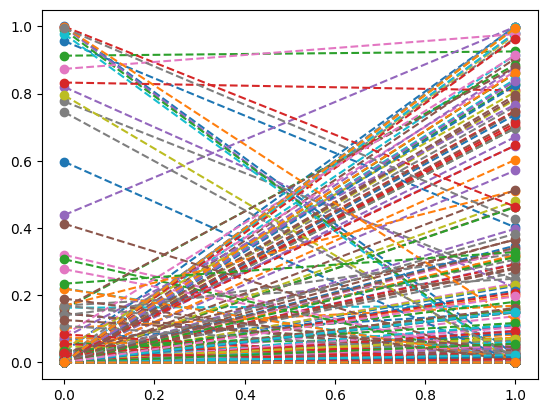

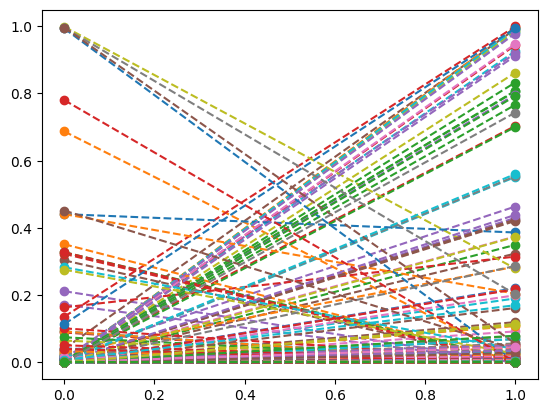

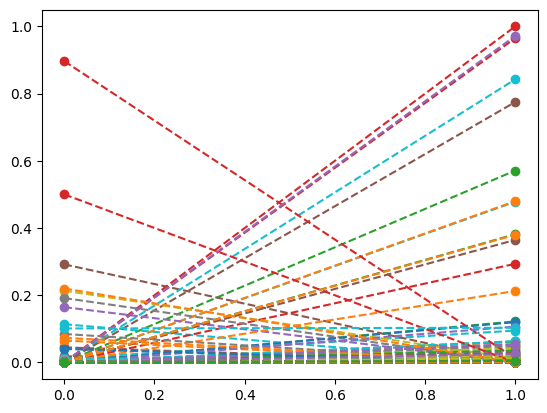

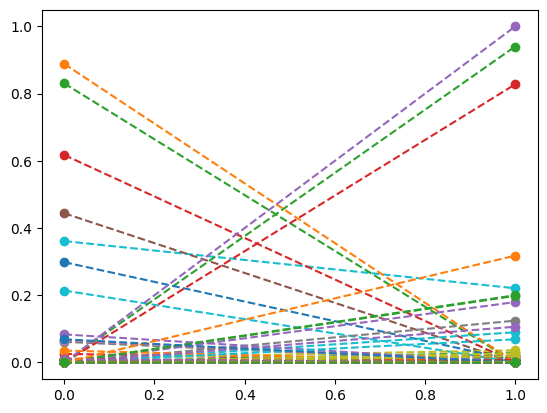

In [209]:
for r in r_hop_range:
    paired_dists = one_to_one_dists.loc[:, [f"{model_name}_{r}_dist" for model_name in production_models['params.model/name']]]
    paired_dists = list(paired_dists.itertuples(index=False, name=None))


    fig, ax = plt.subplots()
    for pair in paired_dists[::10]:
        ax.plot((0, 1), pair, 'o--')

r=0, rc_agg_closer: 0.700
r=1, rc_agg_closer: 0.567
r=2, rc_agg_closer: 0.564
r=3, rc_agg_closer: 0.505


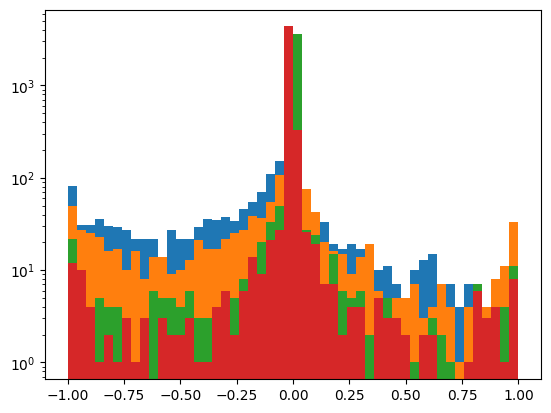

In [207]:
for r in r_hop_range:
    diffs = one_to_one_dists[f"rc_agg_{r}_dist"] - one_to_one_dists[f"bom_{r}_dist"]
    rc_agg_closer = diffs[diffs < 0]
    plt.hist(diffs, bins=50)
    plt.yscale('log')
    print(f"r={r}, rc_agg_closer: {len(rc_agg_closer) / len(diffs):.3f}")

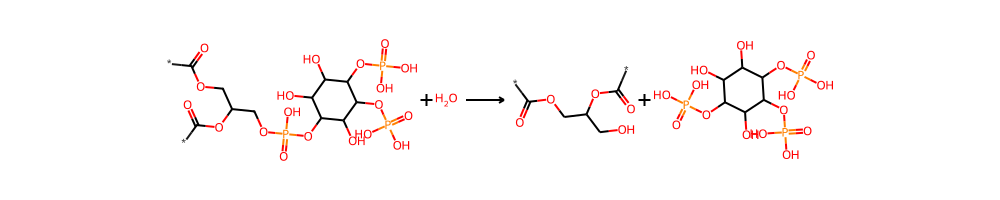

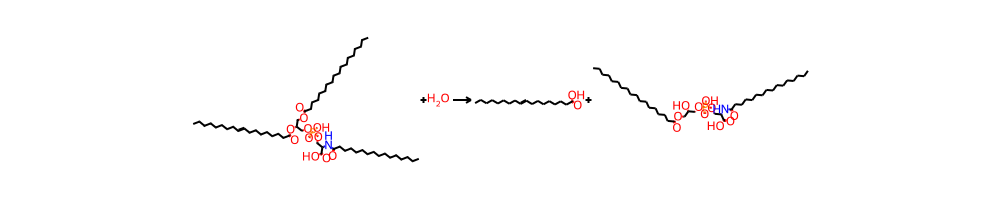

In [127]:
display(SVG(draw_reaction(krs['5969']['smarts'])))
display(SVG(draw_reaction(krs['7658']['smarts'])))